In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [2]:
df = pd.read_csv("data/flattened_data.csv", index_col = "datetime")
df.head()

,1INCHBUSD_open,1INCHBUSD_high,1INCHBUSD_low,1INCHBUSD_close,1INCHBUSD_volume,1INCHUSD_open,1INCHUSD_high,1INCHUSD_low,1INCHUSD_close,1INCHUSD_volume,...,ZRXBUSD_open,ZRXBUSD_high,ZRXBUSD_low,ZRXBUSD_close,ZRXBUSD_volume,ZRXUSD_open,ZRXUSD_high,ZRXUSD_low,ZRXUSD_close,ZRXUSD_volume
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,2.410,2.450,2.406,2.429,27034.1,2.39,2.42,2.39,2.42,47726.30,...,0.8225,0.8375,0.8225,0.8349,2957.0,0.803274,0.815819,0.803274,0.815819,124094.48027
2022-01-01 01:00:00,2.434,2.441,2.421,2.424,15641.5,2.42,2.44,2.41,2.44,109643.15,...,0.8367,0.8367,0.8262,0.8262,7690.0,0.815761,0.818488,0.812232,0.816939,430003.38704
2022-01-01 02:00:00,2.423,2.444,2.418,2.434,10500.5,2.43,2.45,2.43,2.44,22534.85,...,0.8249,0.8305,0.8249,0.8296,1352.0,0.817332,0.841967,0.816370,0.825341,545121.67633
2022-01-01 03:00:00,2.433,2.449,2.433,2.435,11621.9,2.43,2.45,2.43,2.43,16066.99,...,0.8310,0.8327,0.8271,0.8271,5814.0,0.825479,0.826189,0.819242,0.821205,174704.12975
2022-01-01 04:00:00,2.436,2.454,2.415,2.428,18122.9,2.42,2.43,2.40,2.40,35143.16,...,0.8262,0.8326,0.8239,0.8326,4731.0,0.822383,0.824401,0.814999,0.821184,109516.28991


In [3]:
df.shape

(3624, 1955)

In [4]:
## split the dataset into 70:15:15
last_15 = sorted(df.index.values)[-int(0.15*len(df))] # Last 15% indices
last_30 = sorted(df.index.values)[-int(0.3*len(df))] 

train_data = df[(df.index < last_30)].values
val_data = df[(df.index >= last_30) & (df.index < last_15)].values
test_data = df[(df.index >= last_15)].values

print('Training set shape: {}'.format(train_data.shape))
print('Validation set shape: {}'.format(val_data.shape))
print('Test data set: {}'.format(test_data.shape))

Training set shape: (2537, 1955)
Validation set shape: (544, 1955)
Test data set: (543, 1955)


In [5]:
# standardize the dataset
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [6]:
# reshape the data with to window size
seq_len = 30

def reshape_data(seq_len, data, data_scaled):
    X, y = [], []
    for i in range(seq_len, len(data)-1):
        X.append(data_scaled[i-seq_len:i])
        y.append(data[i-seq_len+2:i+2, 2::5]/data[i-seq_len:i, 1::5])
        
    X, y = np.array(X), np.array(y)
    return X, y

X_train, y_train = reshape_data(seq_len, train_data, train_data_scaled)
X_val, y_val = reshape_data(seq_len, val_data, val_data_scaled)
X_test, y_test = reshape_data(seq_len, test_data, test_data_scaled)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (2506, 30, 1955) (2506, 30, 391)
Validation set shape (513, 30, 1955) (513, 30, 391)
Testing set shape (512, 30, 1955) (512, 30, 391)


In [7]:
d_k = 128
d_v = 128
n_heads = 8
ff_dim = 128
batch_size = 64

In [8]:
class T2V(Layer):
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                      shape=(input_shape[-1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.P = self.add_weight(name='P',
                      shape=(input_shape[1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.w = self.add_weight(name='w',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        self.p = self.add_weight(name='p',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        super(T2V, self).build(input_shape)
        
    def call(self, x):
        original = self.w * x + self.p
        sin_trans = tf.math.sin(tf.matmul(x, self.W) + self.P)
        
        return tf.concat([sin_trans, original], -1)
    
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'output_dim': self.output_dim})
        return config

In [9]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.key = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.value = Dense(self.d_v, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    
    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out  

In [10]:
class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()
    
    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))
        self.linear = Dense(input_shape[0][-1], input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    
    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear 

In [11]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer 

    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config      

In [12]:
def create_model():
    '''Initialize time and transformer layers'''
    time_embedding = T2V(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, 1955))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    # x = GlobalAveragePooling1D()(x)
    # x = Flatten()(x)
    x = Dropout(0.15)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.15)(x)
    out = Dense(391)(x)

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
    return model

In [13]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 1955)]   0                                            
__________________________________________________________________________________________________
t2v (T2V)                       (None, 30, 1985)     59610       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 30, 3940)     0           input_1[0][0]                    
                                                                 t2v[0][0]                        
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 30, 3940)     17173720    concatenate[0][0]            

In [14]:
callback = tf.keras.callbacks.ModelCheckpoint('Transformer+ratio.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

In [15]:
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=10, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Epoch 1/10
40/40 [==============================] - 107s 2s/step - loss: 0.7389 - mae: 0.7497 - mse: 0.7389 - val_loss: 0.2553 - val_mae: 0.3739 - val_mse: 0.2553

Epoch 00001: val_loss improved from inf to 0.25526, saving model to Transformer+ratio.hdf5
Epoch 2/10
40/40 [==============================] - 92s 2s/step - loss: 0.1629 - mae: 0.3036 - mse: 0.1629 - val_loss: 0.0171 - val_mae: 0.0827 - val_mse: 0.0171

Epoch 00002: val_loss improved from 0.25526 to 0.01708, saving model to Transformer+ratio.hdf5
Epoch 3/10
40/40 [==============================] - 91s 2s/step - loss: 0.0700 - mae: 0.2047 - mse: 0.0700 - val_loss: 0.0026 - val_mae: 0.0429 - val_mse: 0.0026

Epoch 00003: val_loss improved from 0.01708 to 0.00263, saving model to Transformer+ratio.hdf5
Epoch 4/10
40/40 [==============================] - 92s 2s/step - loss: 0.0556 - mae: 0.1830 - mse: 0.0556 - val_loss: 0.0028 - val_mae: 0.0496 - val_mse: 0.0028

Epoch 00004: val_loss did not improve from 0.00263
Epoch 5/10
40/4

In [16]:
model = tf.keras.models.load_model('Transformer+ratio.hdf5',
                                   custom_objects={'T2V': T2V,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

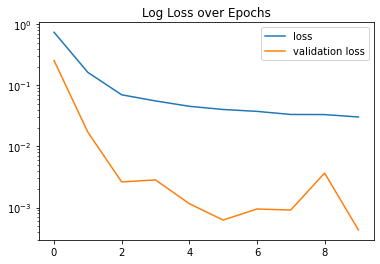

In [17]:
import matplotlib.pyplot as plt
plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Log Loss over Epochs')

plt.legend(['loss', 'validation loss'])

In [18]:
model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

[0.0014546578750014305, 0.02719816006720066, 0.0014546577585861087]

In [19]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

In [20]:
print(y_train_pred.shape, y_val_pred.shape, y_test_pred.shape)

(2506, 30, 391) (513, 30, 391) (512, 30, 391)


In [21]:
from sklearn.metrics import r2_score
r2_array_train = []

for i in range(y_train.shape[1]):
    for j in range(y_train.shape[2]):
        r2_array_train.append(r2_score(np.array(y_train[:, i, j]), np.array(y_train_pred[:, i, j])))

print('---Train set: ')
print('mean value of the r2 array:', np.mean(r2_array_train))
print('median value of the r2 array:', np.median(r2_array_train))

r2_array_val = []

for i in range(y_val.shape[1]):
    for j in range(y_val.shape[2]):
        r2_array_val.append(r2_score(np.array(y_val[:, i, j]), np.array(y_val_pred[:, i, j])))

print('---Validation set: ')
print('mean value of the r2 array:', np.mean(r2_array_val))
print('median value of the r2 array:', np.median(r2_array_val))

r2_array_test = []

for i in range(y_test.shape[1]):
    for j in range(y_test.shape[2]):
        r2_array_test.append(r2_score(np.array(y_test[:, i, j]), np.array(y_test_pred[:, i, j])))

print('---Test set: ')
print('mean value of the r2 array:', np.mean(r2_array_test))
print('median value of the r2 array:', np.median(r2_array_test))

---Train set: 
mean value of the r2 array: -433.86767544078674
median value of the r2 array: -0.23421536633988416
---Validation set: 
mean value of the r2 array: -446.16540012263755
median value of the r2 array: -0.2755343727675623
---Test set: 
mean value of the r2 array: -1.597924324617696
median value of the r2 array: -0.057435344001955824


In [22]:
profit_arr = []
profit_pred_arr = []

X_test_unscaled, y_test_unscaled = reshape_data(seq_len, test_data, test_data)
X_test_last = X_test_unscaled[:,-1,:]
y_test_last = y_test[:,-1,:]
y_test_last_pred = y_test_pred[:,-1,:]

print(X_test_last.shape)
print(y_test_last.shape)
print(y_test_last_pred.shape)

for j in range(y_test_last.shape[-1]):
    profit_pred = 0
    profit = 0
    for i in range(X_test_last.shape[0]-2):
        if X_test_last[i,j*5+3] != 0:
            if y_test_last_pred[i,j] > 1:
                profit_pred = profit_pred - 1000 + 1000*(X_test_last[i+2, j*5+3]/X_test_last[i,j*5+3])
            profit = profit - 1000 + 1000*(X_test_last[i+2, j*5+3]/X_test_last[i,j*5+3])
    profit_arr.append(profit)
    profit_pred_arr.append(profit_pred)

print("baseline profit:", np.sum(profit_arr))
print("profit based on model predictions:", np.sum(profit_pred_arr))

(512, 1955)
(512, 391)
(512, 391)
baseline profit: -44125.45456439162
profit based on model predictions: 14957.819659696444


In [23]:
token = [df.columns[i*5].split('_')[0] for i in range(391)]
for i in range(len(token)):
    print(token[i])
    print('  -baseline: ', profit_arr[i])
    print('  -profit on pred: ', profit_pred_arr[i])

1INCHBUSD
  -baseline:  -46.29996676906626
  -profit on pred:  0
1INCHUSD
  -baseline:  -99.27378958943928
  -profit on pred:  0
AAVEBUSD
  -baseline:  380.21100373340016
  -profit on pred:  0
AAVEUSD
  -baseline:  278.0022391878115
  -profit on pred:  0
ACHUSD
  -baseline:  192.0016575248668
  -profit on pred:  0
ACMBUSD
  -baseline:  -78.42697825566904
  -profit on pred:  0
ADABUSD
  -baseline:  84.71870312313388
  -profit on pred:  118.45525436316393
ADATUSD
  -baseline:  84.26124270784669
  -profit on pred:  98.36363636363626
ADAUSD
  -baseline:  2.4430548312000155
  -profit on pred:  0
ADXBUSD
  -baseline:  -260.91168270301023
  -profit on pred:  0
AERGOBUSD
  -baseline:  214.6337486790717
  -profit on pred:  188.33333333333348
AGLDBUSD
  -baseline:  -165.00733520466952
  -profit on pred:  306.66666666666674
AGLDUSD
  -baseline:  -262.0780801034971
  -profit on pred:  0
ALCXBUSD
  -baseline:  -519.570681152278
  -profit on pred:  58.82352941176464
ALCXUSD
  -baseline:  -563.388819

In [24]:
print('pred profit > profit: ', np.sum([profit_pred_arr[i] > profit_arr[i] for i in range(len(token))]))

pred profit > profit:  272


loop over 30 windows

In [25]:
# average profit
arr = []
arr_pred = []

for k in range(X_test_unscaled.shape[1]):
    X_test_last = X_test_unscaled[:, k, :]
    y_test_last_pred = y_test_pred[:, k, :]
    profit_arr = []
    profit_pred_arr = []

    for j in range(y_test_last.shape[-1]):
        profit_pred = 0
        profit = 0
        for i in range(X_test_last.shape[0]-2):
            if X_test_last[i,j*5+3] != 0:
                if y_test_last_pred[i,j] > 1:
                    profit_pred = profit_pred - 1000 + 1000*(X_test_last[i+2, j*5+3]/X_test_last[i,j*5+3])
                profit = profit - 1000 + 1000*(X_test_last[i+2, j*5+3]/X_test_last[i,j*5+3])
        profit_arr.append(profit)
        profit_pred_arr.append(profit_pred)
    arr.append(np.sum(profit_arr))
    arr_pred.append(np.sum(profit_pred_arr))

print("baseline profit:", np.mean(arr))
print("profit based on model predictions:", np.mean(arr_pred))

baseline profit: -55778.909527619006
profit based on model predictions: 6937.769800019014


In [26]:
def accuracy_func(y_true, y_pred):
    same_dir = 0
    class1 = 0
    total = y_true.shape[0] * y_true.shape[1] * y_true.shape[2]
    for i in range(y_true.shape[0]):
        for j in range(y_true.shape[1]):
            for k in range(y_true.shape[2]):
                if y_true[i,j,k] > 1:
                    class1 += 1
                if (y_true[i,j,k] > 1 and y_pred[i,j,k] > 1) or (y_true[i,j,k] <= 1 and y_pred[i,j,k] <= 1):
                    same_dir += 1
    print('accuracy: ', same_dir / total)
    print('--- baseline')
    print('ratio > 1: ', class1 / total)
    print('ratio <= 1: ', 1 - class1 / total)

In [27]:
print("***** Training set: ")
accuracy_func(y_train, y_train_pred)
print("***** Validation set: ")
accuracy_func(y_val, y_val_pred)
print("***** Test set: ")
accuracy_func(y_test, y_test_pred)

***** Training set: 
accuracy:  0.8156269454587761
--- baseline
ratio > 1:  0.10761987087766853
ratio <= 1:  0.8923801291223314
***** Validation set: 
accuracy:  0.814437747299954
--- baseline
ratio > 1:  0.09930087129351274
ratio <= 1:  0.9006991287064873
***** Test set: 
accuracy:  0.8947846733802216
--- baseline
ratio > 1:  0.10491694639812446
ratio <= 1:  0.8950830536018756
